## Credit: Time Series Forecasting in Python book by Marco Peixeiro published by Manning

Re-wrote code to leverage pandas built-in plotting functionality and improved aesthetics.  Original code was very numpy array-centric.

**NOTE:** This notebook was kept because it shows a very weird plotting behaving when we have quarterly dates that use '01' for the day value for all dates versus a data set that has some of the day values equal to '02'.

In [1]:
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [44]:
df2 = pd.read_csv('../data/jj.csv', parse_dates=['date']).set_index('date')
df2.index

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-02', '1960-10-01',
               '1961-01-01', '1961-04-02', '1961-07-02', '1961-10-01',
               '1962-01-01', '1962-04-02', '1962-07-02', '1962-10-01',
               '1963-01-01', '1963-04-02', '1963-07-02', '1963-10-01',
               '1964-01-01', '1964-04-01', '1964-07-02', '1964-10-01',
               '1965-01-01', '1965-04-02', '1965-07-02', '1965-10-01',
               '1966-01-01', '1966-04-02', '1966-07-02', '1966-10-01',
               '1967-01-01', '1967-04-02', '1967-07-02', '1967-10-01',
               '1968-01-01', '1968-04-01', '1968-07-02', '1968-10-01',
               '1969-01-01', '1969-04-02', '1969-07-02', '1969-10-01',
               '1970-01-01', '1970-04-02', '1970-07-02', '1970-10-01',
               '1971-01-01', '1971-04-02', '1971-07-02', '1971-10-01',
               '1972-01-01', '1972-04-01', '1972-07-02', '1972-10-01',
               '1973-01-01', '1973-04-02', '1973-07-02', '1973-10-01',
      

In [3]:
df = pd.read_csv('../data/jj2.csv', parse_dates=['date']).set_index('date')
df.index

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-01', '1960-10-01',
               '1961-01-01', '1961-04-01', '1961-07-01', '1961-10-01',
               '1962-01-01', '1962-04-01', '1962-07-01', '1962-10-01',
               '1963-01-01', '1963-04-01', '1963-07-01', '1963-10-01',
               '1964-01-01', '1964-04-01', '1964-07-01', '1964-10-01',
               '1965-01-01', '1965-04-01', '1965-07-01', '1965-10-01',
               '1966-01-01', '1966-04-01', '1966-07-01', '1966-10-01',
               '1967-01-01', '1967-04-01', '1967-07-01', '1967-10-01',
               '1968-01-01', '1968-04-01', '1968-07-01', '1968-10-01',
               '1969-01-01', '1969-04-01', '1969-07-01', '1969-10-01',
               '1970-01-01', '1970-04-01', '1970-07-01', '1970-10-01',
               '1971-01-01', '1971-04-01', '1971-07-01', '1971-10-01',
               '1972-01-01', '1972-04-01', '1972-07-01', '1972-10-01',
               '1973-01-01', '1973-04-01', '1973-07-01', '1973-10-01',
      

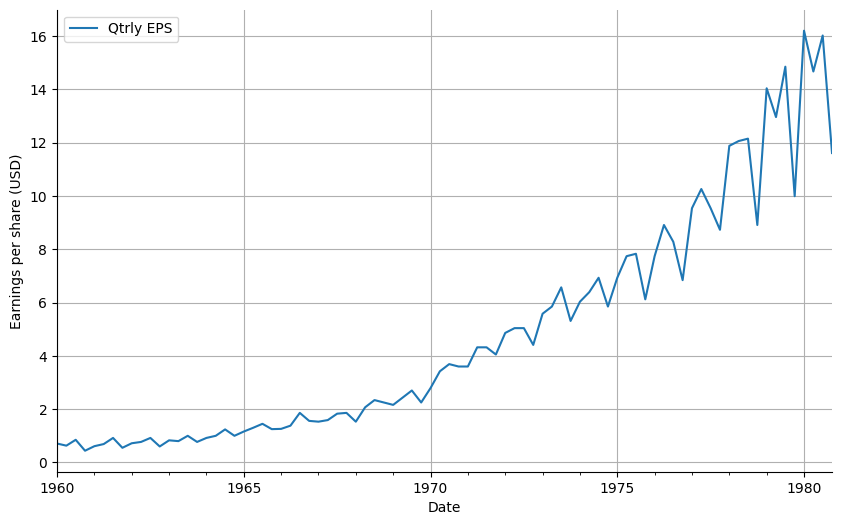

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

df.plot(kind='line', use_index=True, y='data', label='Qtrly EPS', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
sns.despine()
plt.grid(visible=True)
plt.show()

In [8]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574766
p-value: 1.0


This block of code returns an ADF statistic of 2.74 with a p-value of 1.0. Since the ADF
statistic is not a large negative number, and the p-value is larger than 0.05, we cannot
reject the null hypothesis, meaning that our series is not stationary.

We need to determine how many times the series must be differenced to become
stationary. This will then set the order of integration d. We can apply a first-order dif-
ferencing and test for stationarity.

In [9]:
df = df.assign(eps_diff=df['data'].diff(1))

In [10]:
df.head()

,data,eps_diff
date,,
1960-01-01,0.71,NaN
1960-04-01,0.63,-0.08
1960-07-01,0.85,0.22
1960-10-01,0.44,-0.41
1961-01-01,0.61,0.17


In [11]:
ad_fuller_result = adfuller(df['eps_diff'].dropna())

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.4074097636380437
p-value: 0.9088542416911309


This results in an ADF statistic of –0.41 and a p-value of 0.9. Again, the ADF statistic is
not a large negative number, and the p-value is larger than 0.05. Therefore, we cannot
reject the null hypothesis and we must conclude that after a first-order differencing,
the series is not stationary.

Let’s try differencing again to see if the series becomes stationary:

In [12]:
df = df.assign(eps_diff2=df['eps_diff'].diff(1))

In [13]:
df.head()

,data,eps_diff,eps_diff2
date,,,
1960-01-01,0.71,NaN,NaN
1960-04-01,0.63,-0.08,NaN
1960-07-01,0.85,0.22,0.30
1960-10-01,0.44,-0.41,-0.63
1961-01-01,0.61,0.17,0.58


In [14]:
ad_fuller_result = adfuller(df['eps_diff2'].dropna())

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.5851628747931694
p-value: 0.006051099869603393


This results in an ADF statistic of –3.59 and a p-value of 0.006. Now that we have a
p-value smaller than 0.05 and a large negative ADF statistic, we can reject the null
hypothesis and conclude that our series is stationary. It took two rounds of differ-
encing to make our data stationary, which means that our order of integration is 2,
so d = 2.

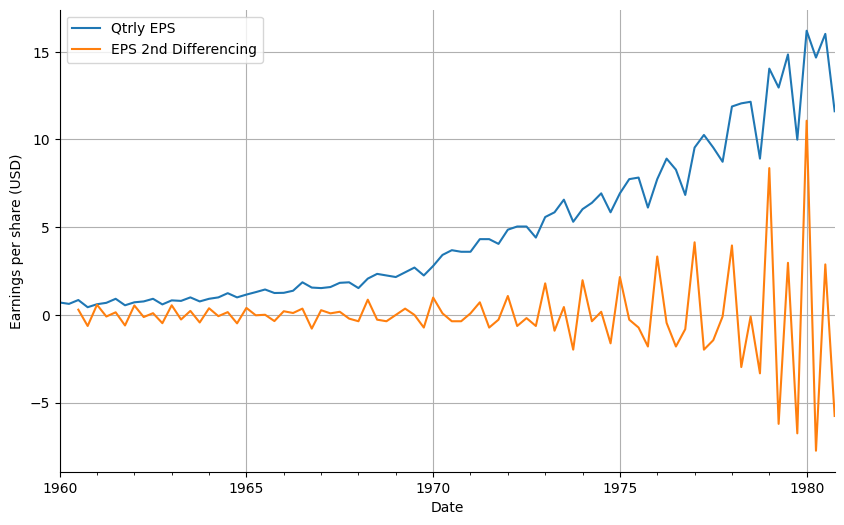

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

df.plot(kind='line', use_index=True, y='data', label='Qtrly EPS', ax=ax)
df.plot(kind='line', use_index=True, y='eps_diff2', label='EPS 2nd Differencing', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
sns.despine()
plt.grid(visible=True)
plt.show()

Before we move on to fitting different combinations of ARIMA(p,d,q) models, we must separate our data into train and test sets. We will hold out the last year of data for testing. This means that we will fit the model with data from 1960 to 1979 and predict the quarterly EPS in 1980 to evaluate the quality of our model against the observed values in 1980. In plot below, the testing period is the shaded area.

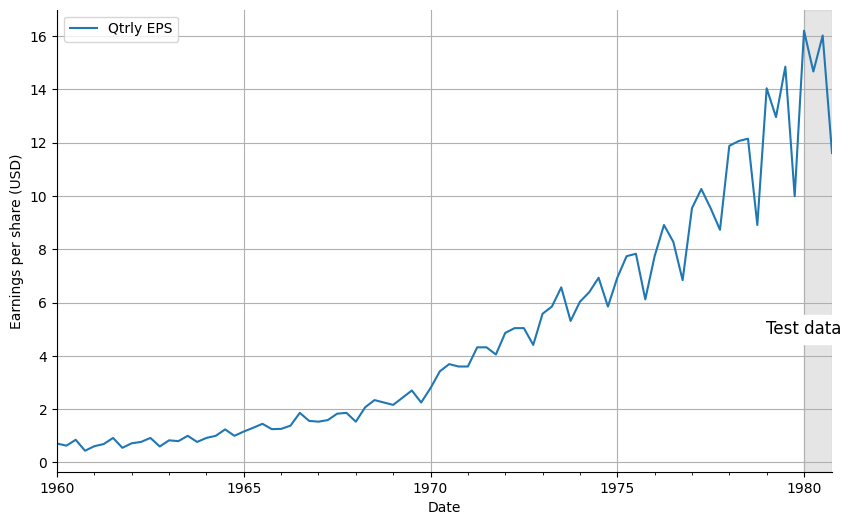

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

df.plot(kind='line', use_index=True, y='data', label='Qtrly EPS', ax=ax)
ax.axvspan('1980-01-01', '1980-10-01', color='#808080', alpha=0.2, label='Test Data')
plt.text('1980-01-01', 5, 'Test data', fontsize=12, va='center', ha='center', backgroundcolor='white')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
sns.despine()
plt.grid(visible=True)
plt.show()

To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function:

In [17]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
ps = range(0, 4, 1)  # Create a list of possible values for p from 0 inclusively to 4 exclusively, with steps of 1.
qs = range(0, 4, 1)  # Create a list of possible values for q from 0 inclusively to 4 exclusively, with steps of 1
d = 2                # Set to 2 since we had to perform differencing twice to achieve stationarity

order_list = list(product(ps, qs))  # Generate a list containing all unique combinations of (p,q)

Note that we do not give a range of values for the parameter d because it has a very specific definition: it is the number of times a series must be differenced to become stationary. Hence, it must be set to a specific value, which in this case is 2.  Furthermore, d must be constant in order to compare models using the AIC. Varying d would change the likelihood function used in the calculation of the AIC value, so comparing models using the AIC as a criterion would not be valid anymore.  We can now run the optimize_ARIMA function using the training set. The function returns a DataFrame with the model that has the lowest AIC at the top.

In [19]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.270561
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430627
4,"(0, 3)",194.654716
5,"(0, 2)",209.274484
6,"(2, 3)",220.666938
7,"(1, 3)",228.267935
8,"(1, 2)",228.935814
9,"(2, 2)",229.974707


The model parameters with the lowest AIC are (p=3, d=2, q=3)

In [20]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.635
Date:                Sun, 01 Oct 2023   AIC                            115.271
Time:                        14:48:35   BIC                            131.768
Sample:                    01-01-1960   HQIC                           121.875
                         - 10-01-1979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990      0.037    -27.164      0.000      -1.071      -0.927
ar.L2         -0.9876      0.040    -24.869      0.000      -1.065      -0.910
ar.L3         -0.9762      0.026    -38.131      0.0

In [21]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.635
Date:                Sun, 01 Oct 2023   AIC                            115.271
Time:                        14:48:36   BIC                            131.768
Sample:                    01-01-1960   HQIC                           121.875
                         - 10-01-1979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990      0.037    -27.164      0.000      -1.071      -0.927
ar.L2         -0.9876      0.040    -24.869      0.000      -1.065      -0.910
ar.L3         -0.9762      0.026    -38.131      0.0

In [61]:
len(ax_list)

5

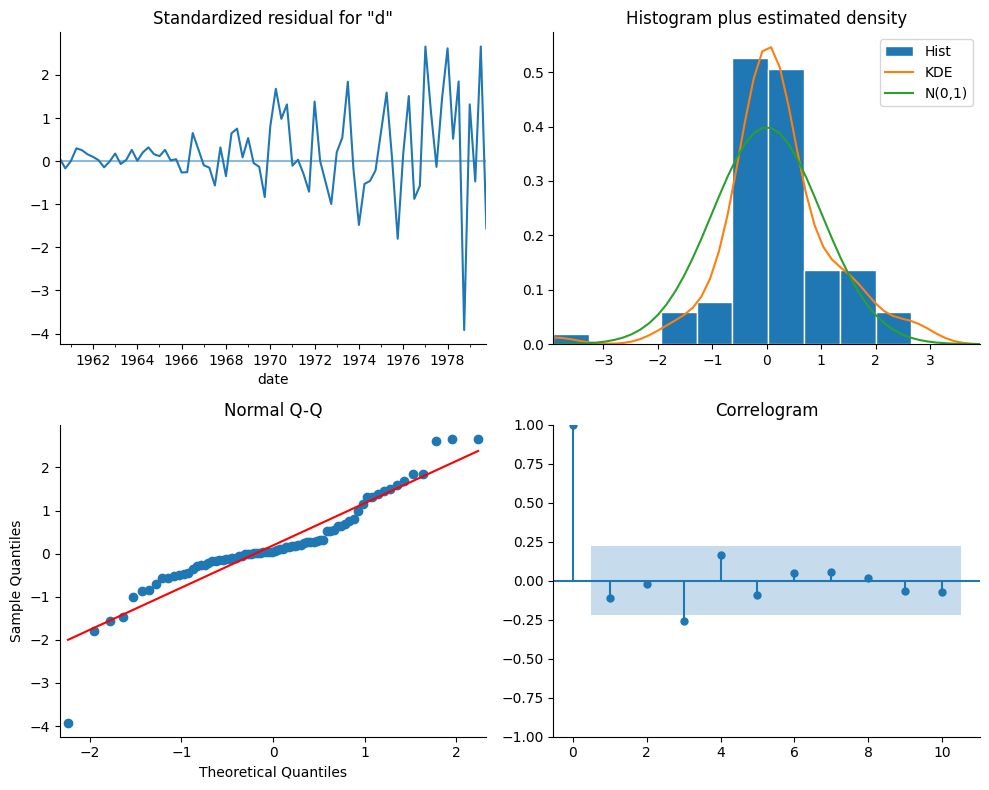

In [66]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
sns.despine()
plt.show()

The top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. At the top right is the distribution of the residuals. We can see it is fairly close to a normal distribution. The Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise. Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, as it means that the model’s errors are random.

The last step is to evaluate the residuals from a quantitative standpoint. We’ll thus apply the Ljung-Box test to determine whether the residuals are correlated. We’ll apply the test on the first 10 lags and study the p-values. If all p-values are greater than 0.05, we cannot reject the null hypothesis and we’ll conclude that the residuals are not correlated, just like white noise.

In [23]:
residuals = model_fit.resid

lungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lungbox_df

,lb_stat,lb_pvalue
1,1.669504,0.196325
2,1.670686,0.433726
3,7.247716,0.064408
4,9.200575,0.056277
5,9.828924,0.080230
6,10.064819,0.121949
7,10.319878,0.171159
8,10.351977,0.241185
9,10.696263,0.297104
10,11.137740,0.346888


Running the Ljung-Box test on the first 10 lags of the model’s residuals returns a list of p-values that are all larger than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are not correlated, just like white noise.

Our ARIMA(3,2,3) model has passed all the checks, and it can now be used for forecasting. Remember that our test set is the last four data points, corresponding to the four quarterly EPS reported in 1980. As a benchmark for our model, we will use the naive seasonal method. This means that we’ll take the EPS of the first quarter of 1979 and use it as a forecast for the EPS of the first quarter of 1980. Then the EPS of the second quarter of 1979 will be used as a forecast for the EPS of the second quarter of 1980, and so on. Remember that we need a benchmark, or a baseline model, when modeling to determine whether the model we develop is better than a naive method. The performance of a model must always be assessed relative to a baseline model.

In [24]:
test = df.iloc[-4:]   # The test set corresponds to the last four data points

# The naive seasonal forecast is implemented by selecting the quarterly EPS reported in 1979
# and using the same values as a forecast for the year 1980
# test['naive_seasonal'] = df['data'].iloc[76:80].values  This was original code, but I think it is easier
# to filter using date range rather than having to come up with proper index integers
test = test.assign(naive_seasonal=df['1979-01-01':'1979-12-31']['data'].values)
test

,data,eps_diff,eps_diff2,naive_seasonal
date,,,,
1980-01-01,16.20,6.21,11.07,14.04
1980-04-01,14.67,-1.53,-7.74,12.96
1980-07-01,16.02,1.35,2.88,14.85
1980-10-01,11.61,-4.41,-5.76,9.99


`train` dataframe has 80 rows of data and so the index for the next row will be 80 - see comment in next cell

In [25]:
len(train)

80

In [26]:
# Get the predicted values for the year 1980
# Where did 80 and 83 come from?
# Had to re-visit train dataframe which is data through end of 1979 and it's last row's index is 79
# Therefore, the future values or start index is 80 and also since this is quarterly data
# end index = 83 (80, 81, 82, 83)
# ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

# Unfortunately, the following line does not work using string dates even though documentation indicates it should:
ARIMA_pred = model_fit.get_prediction(start='1980-01-01', end='1980-10-01').predicted_mean

# When I fitted the model with the training data earlier in this notebook - see input cell # 16 above
# SARIMAX() has a dates= parameter which I tried to set to train.index (dates=train.index), but got an error
# that I need to set the frequency / freq= but the dates that this data set came with, did not fit to any of the
# allowable pandas date offset aliases: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# I think because of this, I was not able to pass string dates to the get_prediction() method

# Assign the forecasts to the ARIMA_pred column
test = test.assign(ARIMA_pred=ARIMA_pred.values)
test

,data,eps_diff,eps_diff2,naive_seasonal,ARIMA_pred
date,,,,,
1980-01-01,16.20,6.21,11.07,14.04,15.857834
1980-04-01,14.67,-1.53,-7.74,12.96,14.379995
1980-07-01,16.02,1.35,2.88,14.85,16.371491
1980-10-01,11.61,-4.41,-5.76,9.99,11.678241


In [27]:
test.index

DatetimeIndex(['1980-01-01', '1980-04-01', '1980-07-01', '1980-10-01'], dtype='datetime64[ns]', name='date', freq='QS-JAN')

In [41]:
df.index

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-01', '1960-10-01',
               '1961-01-01', '1961-04-01', '1961-07-01', '1961-10-01',
               '1962-01-01', '1962-04-01', '1962-07-01', '1962-10-01',
               '1963-01-01', '1963-04-01', '1963-07-01', '1963-10-01',
               '1964-01-01', '1964-04-01', '1964-07-01', '1964-10-01',
               '1965-01-01', '1965-04-01', '1965-07-01', '1965-10-01',
               '1966-01-01', '1966-04-01', '1966-07-01', '1966-10-01',
               '1967-01-01', '1967-04-01', '1967-07-01', '1967-10-01',
               '1968-01-01', '1968-04-01', '1968-07-01', '1968-10-01',
               '1969-01-01', '1969-04-01', '1969-07-01', '1969-10-01',
               '1970-01-01', '1970-04-01', '1970-07-01', '1970-10-01',
               '1971-01-01', '1971-04-01', '1971-07-01', '1971-10-01',
               '1972-01-01', '1972-04-01', '1972-07-01', '1972-10-01',
               '1973-01-01', '1973-04-01', '1973-07-01', '1973-10-01',
      

In [40]:
df2.index

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-02', '1960-10-01',
               '1961-01-01', '1961-04-02', '1961-07-02', '1961-10-01',
               '1962-01-01', '1962-04-02', '1962-07-02', '1962-10-01',
               '1963-01-01', '1963-04-02', '1963-07-02', '1963-10-01',
               '1964-01-01', '1964-04-01', '1964-07-02', '1964-10-01',
               '1965-01-01', '1965-04-02', '1965-07-02', '1965-10-01',
               '1966-01-01', '1966-04-02', '1966-07-02', '1966-10-01',
               '1967-01-01', '1967-04-02', '1967-07-02', '1967-10-01',
               '1968-01-01', '1968-04-01', '1968-07-02', '1968-10-01',
               '1969-01-01', '1969-04-02', '1969-07-02', '1969-10-01',
               '1970-01-01', '1970-04-02', '1970-07-02', '1970-10-01',
               '1971-01-01', '1971-04-02', '1971-07-02', '1971-10-01',
               '1972-01-01', '1972-04-01', '1972-07-02', '1972-10-01',
               '1973-01-01', '1973-04-02', '1973-07-02', '1973-10-01',
      

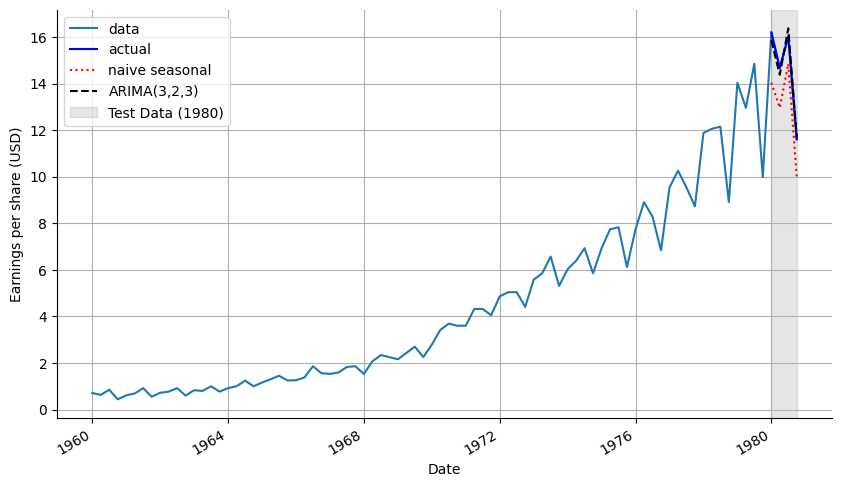

In [49]:
fig, ax = plt.subplots(figsize=(10,6))

# The plotting works if plotting df2, but does not work if using df!!!  Very strange!
# df.plot(kind='line', use_index=True, y='data', label='data', ax=ax)         # Does not work
df2.plot(kind='line', use_index=True, y='data', label='data', ax=ax)         # works
# ax.plot(df.index, df['data'], color='cyan', label='data', alpha=0.7)
ax.plot(test.index, test['data'], 'b-', label='actual')
ax.plot(test.index, test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test.index, test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.axvspan('1980-01-01', '1980-10-01', color='#808080', alpha=0.2, label='Test Data (1980)')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc='upper left')
sns.despine()
plt.grid(visible=True)
plt.show()

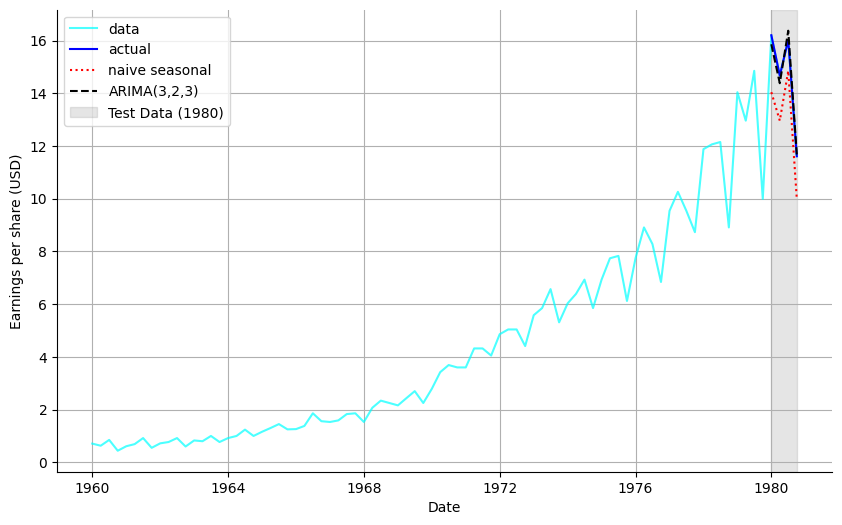

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

# df2.plot(kind='line', use_index=True, y='data', ax=ax)
ax.plot(df.index, df['data'], color='cyan', label='data', alpha=0.7)
ax.plot(test.index, test['data'], 'b-', label='actual')
ax.plot(test.index, test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test.index, test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.axvspan('1980-01-01', '1980-10-01', color='#808080', alpha=0.2, label='Test Data (1980)')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc='upper left')
sns.despine()
plt.grid(visible=True)
plt.show()

Same plot as above, but displaying 1975 to 1980 to enlarge the area of interest.

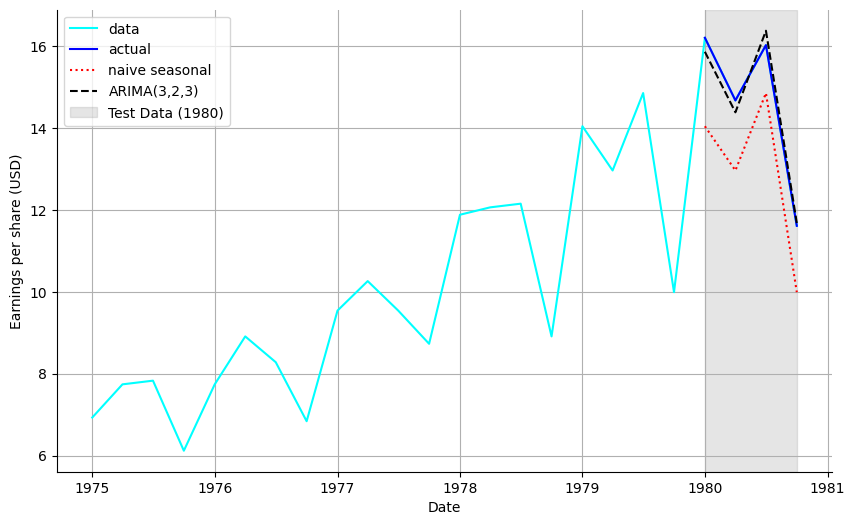

In [51]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['1975':'1980'].index, df['1975':'1980']['data'], color='cyan', label='data')
ax.plot(test.index, test['data'], 'b-', label='actual')
ax.plot(test.index, test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test.index, test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.axvspan('1980-01-01', '1980-10-01', color='#808080', alpha=0.2, label='Test Data (1980)')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc='upper left')
sns.despine()
plt.grid(visible=True)
plt.show()

Now, let's plot the actual, prediction, and naive seasonal series

We can see the naive seasonal forecast as a dotted line and the ARIMA(3,2,3) forecasts as a dashed line. The ARIMA(3,2,3) model predicted the quarterly EPS with a very small error.  We can quantify that error by measuring the mean absolute percentage error (MAPE) and display the metric for each forecasting method in a bar plot,

In [37]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7177121449878163


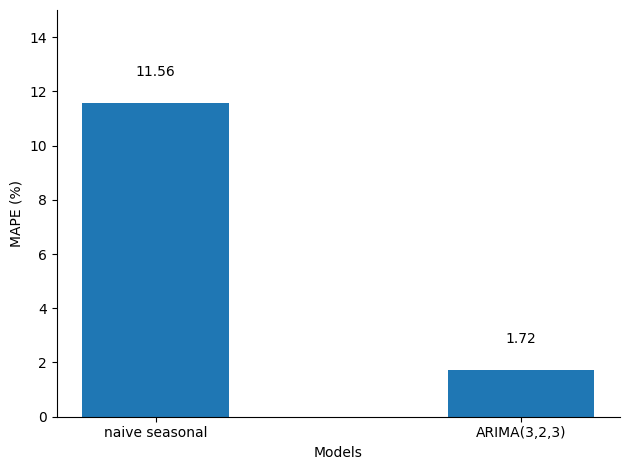

In [39]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()
sns.despine()
plt.show()

You can see that the MAPE for the naive seasonal forecast is 11.56%, while the MAPE for the ARIMA(3,2,3) model is 2.19%, which roughly one fifth of the benchmark value. This means that our predictions are on average 2.19% off from the actual values. The ARIMA(3,2,3) model is clearly a better model than the naive seasonal method.